In [1]:
import sys
sys.path.append("..")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from system import *

In [2]:
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx("float64")

plt.style.use("../lib/rapport.mplstyle")
%load_ext autoreload
%autoreload 2

def saveto(fig, path, ncol=2):
    lgd = fig.legend(loc='lower left',# mode='expand',-
                     ncol=ncol,
                     bbox_to_anchor=(0.3, 1.02, 1, 0.2))
    fig.savefig(f"../latex/figures/{path}.pdf", bbox_inches='tight') 

In [3]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [4]:
class Ansatz(tf.keras.Model):
    def __init__(self, nodes, hidden_units):
        super().__init__()
        
        self.Layers = []
        for node in nodes:
            self.Layers.append(tf.keras.layers.Dense(node))
        
        self.out = tf.keras.layers.Dense(1)
        
        self.w = tf.keras.layers.Dense(hidden_units)
        self.hidden_initial = tf.Variable(tf.ones((1, hidden_units), dtype=tf.dtypes.float64))
    
    
    def call(self, x):
        y = tf.concat((self.hidden, x), axis=1)
        for layer in self.Layers:
            y = tf.math.tanh(layer(y))

        return tf.math.exp(self.out(y))

    
    def rnn_forward(self, x):
        x = tf.concat((self.hidden, x), axis=1)
        self.hidden = tf.tanh(self.w(x))
    
    
    def hidden_reset(self, batch_size):
        self.hidden = tf.repeat(self.hidden_initial, batch_size, axis=0)
           
    
@tf.function
def loss(system, x):
    batch_size = x.shape[0]
    num_part = system.num_part
    dim = system.dim
    
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]
    
    psi = 1
    system.Ansatz.hidden_reset(batch_size)
    for i in range(num_part):
        psi *= system.Ansatz(_x2[:,i*dim:(i+1)*dim])
        system.Ansatz.rnn_forward(_x2[:,i*dim:(i+1)*dim])
    
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(num_part*dim):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    lap = 1/psi*(d2_psi)
    
    E_L = -0.5*lap + system.External(x) + system.Internal(x, num_part, dim)

    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    loss_value = 2*tf.math.reduce_mean(tf.math.log(psi)*(E_L - E))
    
    return E, loss_value, E_L


@tf.function
def grad(system, x):
    with tf.GradientTape() as tape:
        E, loss_value, _ = loss(system, x)

    return E, tape.gradient(loss_value, system.Ansatz.trainable_variables)


def train(system, num_epochs, batch_size, optimizer, verbose = True):
    energy = []
    
    for epoch in tqdm(range(num_epochs)):
        x = []
        
        system.Ansatz.hidden_reset(batch_size)
        for i in range(system.num_part):
            x.append(system.Sampler(batch_size)[0])
            system.Ansatz.rnn_forward(x[-1])

        x = tf.concat(x, axis=1)
        
        E, gradients = grad(system, x)
        energy.append(E.numpy())

        optimizer.apply_gradients(zip(gradients, system.Ansatz.trainable_variables))
        
        if verbose:
            if epoch%100 == 0: 
                print(f"epoch: {epoch}, Energy: {E}")
    
    return energy


def observables(system, batch_size, x = None):
    if (x == None):
        x = system.Sampler(batch_size)
    
    _, _, E_L = loss(system, x)
    E = tf.math.reduce_mean(E_L).numpy()
    E2 = tf.math.reduce_mean(E_L**2).numpy()
    Var = E2 - E**2
    return E, Var


optimizer = tf.keras.optimizers.Adam()

# Non-interacting Bosons in 2D Harmonic Trap

### N = 2

In [5]:
tf.random.set_seed(42)
np.random.seed(42)


ansatz = Ansatz(nodes = (32, 32), hidden_units=5)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=0, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 2,
                 dim = 2,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [6]:
num_epochs = 500
batch_size = 1000

energy1 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 14.805463208055155
epoch: 100, Energy: 2.5207533259805235
epoch: 200, Energy: 2.057683248809444
epoch: 300, Energy: 2.0361038902395068
epoch: 400, Energy: 2.0629011781345565



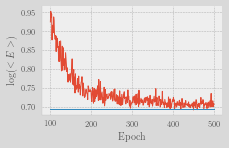

In [7]:
epochs = [i for i in range(num_epochs)]
plt.plot(epochs[100:], np.log(energy1[100:]), label = "Training")
plt.plot(epochs[100:], np.log(2)*np.ones_like(epochs[100:]), label = "Exact")
plt.xlabel("Epoch")
plt.ylabel("$\log(<E>)$")
plt.grid()
plt.show()


In [8]:
N = 100000
system.Ansatz.hidden_reset(N)
print(f"{system.Sampler(N)[1]/(20*N)}")

0.6301625


#### Estimate energy

In [9]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [10]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

E=2.02955+-0.00150
Var=0.22527


### N = 6

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (32, 32), hidden_units=5)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=0, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 6,
                 dim = 2,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [12]:
num_epochs = 500
batch_size = 1000

energy2 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 44.94935501272508
epoch: 100, Energy: 8.02660812987321
epoch: 200, Energy: 6.129673304110283
epoch: 300, Energy: 6.063555687445078
epoch: 400, Energy: 6.092954320589398



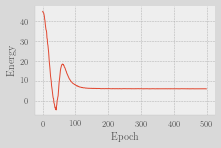

In [13]:
epochs = [i for i in range(num_epochs)]
plt.plot(epochs, energy2)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.grid()
plt.show()

In [14]:
N = 100000
system.Ansatz.hidden_reset(N)
print(f"{system.Sampler(N)[1]/(20*N)}")

0.626924


#### Estimate Energy

In [15]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [16]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

E=6.06959+-0.00204
Var=0.41721


# Non-interacting Bosons in 3D Harmonic Trap

### N=2

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (32, 32), hidden_units=5)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=0, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 2,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [18]:
num_epochs = 500
batch_size = 1000

energy3 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 21.91457104901991
epoch: 100, Energy: 3.082640619830652
epoch: 200, Energy: 3.0502124592559166
epoch: 300, Energy: 3.007347353893931
epoch: 400, Energy: 3.041047178782835



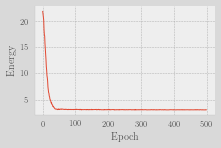

In [19]:
epochs = [i for i in range(num_epochs)]
#plt.figure(figsize=(20,10))
plt.plot(epochs, energy3)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.grid()
plt.show()

In [20]:
N = 100000
system.Ansatz.hidden_reset(N)
print(f"{system.Sampler(N)[1]/(20*N)}")

0.53871


#### Estimate Energy

In [21]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [22]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

E=3.02379+-0.00138
Var=0.19166


### N=6

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (32, 32), hidden_units=5)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=0, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 6,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [24]:
num_epochs = 1000
batch_size = 1000

energy4 = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 66.29183977006753
epoch: 100, Energy: 12.670495073831237
epoch: 200, Energy: 9.497508926054472
epoch: 300, Energy: 9.180453315762184
epoch: 400, Energy: 9.205634662022462
epoch: 500, Energy: 9.159328459790613
epoch: 600, Energy: 9.116073253028244
epoch: 700, Energy: 9.191799137976213
epoch: 800, Energy: 9.119183012585712
epoch: 900, Energy: 9.13883745762275



In [25]:
N = 100000
system.Ansatz.hidden_reset(N)
print(f"{system.Sampler(N)[1]/(20*N)}")

0.5208685


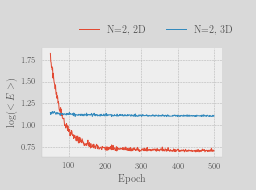

In [31]:
epochs = [i for i in range(500)]

fig = plt.figure()
plt.plot(epochs[50:], np.log(energy1[50:]), label = "N=2, 2D")
plt.plot(epochs[50:], np.log(energy3[50:]), label = "N=2, 3D")
#plt.ylim([1.5, 6])
plt.xlabel("Epoch")
plt.ylabel("$\log(<E>)$")
plt.grid()
saveto(fig, "many_part_nonint_training1", ncol=2)
plt.show()

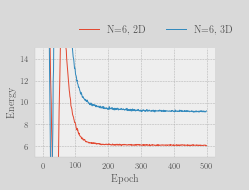

In [27]:
fig = plt.figure()
plt.plot(epochs, np.log(energy2), label = "N=6, 2D")
plt.plot(epochs, np.log(energy4[:500]), label = "N=6, 3D")
plt.ylim([5, 15])
plt.xlabel("Epoch")
plt.ylabel("$\log(<E>)$")
plt.grid()
saveto(fig, "many_part_nonint_training2", ncol=2)
plt.show()

#### Estimate Energy

In [ ]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [ ]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

# Two Interacting Bosons in 1D Harmonic Trap

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (64, 32), hidden_units=5)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=1, beta=0.1)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 2,
                 dim = 1,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [33]:
num_epochs = 2000
batch_size = 2000

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 8.651561972462135
epoch: 100, Energy: 2.9757232834069254
epoch: 200, Energy: 2.8225252858277474
epoch: 300, Energy: 2.8442992975845547
epoch: 400, Energy: 2.8081800222189024
epoch: 500, Energy: 2.755480230986888
epoch: 600, Energy: 2.6845837481692216
epoch: 700, Energy: 2.720716380681799
epoch: 800, Energy: 2.597771187493223
epoch: 900, Energy: 2.6134255767084924
epoch: 1000, Energy: 2.6064841264204497
epoch: 1100, Energy: 2.6005635377606113
epoch: 1200, Energy: 2.5554442861495987
epoch: 1300, Energy: 2.5760536658197
epoch: 1400, Energy: 2.5724218175830367
epoch: 1500, Energy: 2.5581822921257964
epoch: 1600, Energy: 2.555956003817415
epoch: 1700, Energy: 2.552186147848979
epoch: 1800, Energy: 2.539618370253722
epoch: 1900, Energy: 2.560139260090995



No handles with labels found to put in legend.


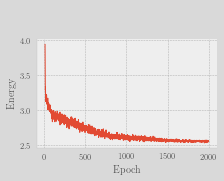

In [35]:
epochs = [i for i in range(num_epochs)]
fig = plt.figure()
plt.plot(epochs[10:], energy[10:])
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.grid()
saveto(fig, "many_part_int_training1", ncol=2)
plt.show()

#### Estimate Energy

In [36]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [37]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

E=2.55019+-0.00091
Var=0.08321


#### One-Body Density

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

N = 400000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

pos = tf.concat(x, axis=0)
bins = np.linspace(-8, 8, 100)
density = oneBodyDensity(pos, bins, mode="1D")/N

In [ ]:
fig = plt.figure()
plt.plot(bins, density)
plt.xlabel("Position")
plt.ylabel("Ampltitude")
saveto(fig, "many_part_int_onebody", ncol=2)
plt.show()

### Conditional Distributions

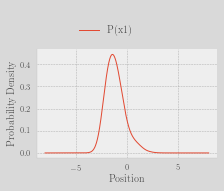

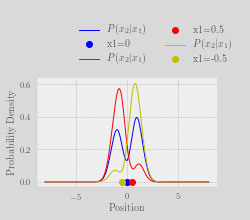

In [34]:
N = 1000
x = np.linspace(-8, 8, N).reshape(-1,1)
dx = x[1] - x[0]
x = tf.convert_to_tensor(x, dtype=tf.dtypes.float64)
system.Ansatz.hidden_reset(N)
P1 = system.Ansatz(x).numpy()**2
P1 = P1/(dx*np.sum(P1))


x_a = 0
system.Ansatz.rnn_forward(x_a*tf.ones((N,1), dtype=tf.dtypes.float64))
P2_a = system.Ansatz(x).numpy()**2
P2_a = P2_a/(dx*np.sum(P2_a))

system.Ansatz.hidden_reset(N)
x_b = 0.5
system.Ansatz.rnn_forward(x_b*tf.ones((N,1), dtype=tf.dtypes.float64))
P2_b = system.Ansatz(x).numpy()**2
P2_b = P2_b/(dx*np.sum(P2_b))

system.Ansatz.hidden_reset(N)
x_c = -0.5
system.Ansatz.rnn_forward(x_c*tf.ones((N,1), dtype=tf.dtypes.float64))
P2_c = system.Ansatz(x).numpy()**2
P2_c = P2_c/(dx*np.sum(P2_c))


fig = plt.figure()
plt.plot(x, P1, label = "P(x1)")
plt.xlabel("Position")
plt.ylabel("Probability Density")
plt.grid()
saveto(fig, "many_part_con1", ncol=2)
plt.show()


fig = plt.figure()
plt.plot(x, P2_a, "b", label = "$P(x_{2}|x_{1})$")
plt.plot(x_a, 0, "bo", label = "x1=0")
plt.plot(x, P2_b, "r", label = "$P(x_{2}|x_{1})$")
plt.plot(x_b, 0, "ro", label = "x1=0.5")
plt.plot(x, P2_c, "y", label = "$P(x_{2}|x_{1})$")
plt.plot(x_c, 0, "yo", label = "x1=-0.5")
plt.xlabel("Position")
plt.ylabel("Probability Density")
plt.grid()
saveto(fig, "many_part_con2", ncol=2)
plt.show()

### Metropolis Sampling

In [ ]:
N = 100
x = np.linspace(-4, 4, N).reshape(-1,1)
dx = x[1] - x[0]
x = tf.convert_to_tensor(x, dtype=tf.dtypes.float64)

x1 = 0.5
system.Ansatz.hidden_reset(N)
system.Ansatz.rnn_forward(x1*tf.ones((N,1), dtype=tf.dtypes.float64))
P2 = system.Ansatz(x).numpy()**2
P2 = P2/(dx*np.sum(P2))

M = 100000
system.Ansatz.hidden_reset(M)
system.Ansatz.rnn_forward(x1*tf.ones((M,1), dtype=tf.dtypes.float64))

system.Sampler.steps = 10
sample1 = system.Sampler(M)[0]

system.Sampler.steps = 20
sample2 = system.Sampler(M)[0]

system.Sampler.steps = 50
sample3 = system.Sampler(M)[0]

density1 = oneBodyDensity(sample1, x, mode="1D")/M
density2 = oneBodyDensity(sample2, x, mode="1D")/M
density3 = oneBodyDensity(sample3, x, mode="1D")/M

In [ ]:
fig = plt.figure()
plt.plot(x, P2, label = "$P(x_{2}|x_{1})$")
plt.plot(x, density1, "--", label = "Steps=10")
plt.plot(x, density2, "--", label = "Steps=20")
plt.plot(x, density3, "--", label = "Steps=50")
plt.xlabel("x")
plt.ylabel("Amplitude")
plt.grid()
saveto(fig, "many_part_met", ncol=2)

plt.show()

# Two Interacting Bosons in 2D Harmonic Trap

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (64, 32), hidden_units=10)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=1, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 2,
                 dim = 2,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [ ]:
num_epochs = 1000
batch_size = 4000

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

In [ ]:
epochs = [i for i in range(num_epochs)]
plt.plot(epochs[10:], energy[10:])
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.grid()
plt.show()

In [ ]:
N = 10000
system.Ansatz.hidden_reset(N)
print(f"{system.Sampler(N)[1]}/{20*N}")

#### Estimate Energy

In [ ]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [ ]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

# Two Interacting Bosons in 3D Harmonic Trap

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

ansatz = Ansatz(nodes = (64, 32), hidden_units=10)
external = HarmonicOsc(omega=1)
internal = Coulomb(alpha=1, beta=0)
sampler = Metropolis(step_length=1, steps=20)

system = System(num_part = 2,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

In [ ]:
num_epochs = 1000
batch_size = 4000

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

In [ ]:
epochs = [i for i in range(num_epochs)]
plt.plot(epochs[10:], energy[10:])
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.grid()
plt.show()

In [ ]:
N = 100000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

x = tf.concat(x, axis=1)
E, _, E_L = loss(system, x)

E2 = tf.math.reduce_mean(E_L**2)
Var = E2 - E**2

In [ ]:
print(f"E={E:.5f}+-{np.sqrt(Var/N):.5f}")
print(f"Var={Var:.5f}")

### One-Body Density

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

N = 1000000
system.Ansatz.hidden_reset(N)
x = []

for i in range(system.num_part):   
    x.append(system.Sampler(N)[0])
    system.Ansatz.rnn_forward(x[-1])

pos = tf.concat(x, axis=0)
bins = np.linspace(0, 3, 100)
density = oneBodyDensity(pos, bins, mode="radial3D")/N

In [ ]:
fig = plt.figure()
plt.plot(bins, density)
plt.grid()
plt.xlabel("r")
plt.ylabel("$\rho(r)$")
saveto(fig, "many_part_3D", ncol=2)
plt.show()